### Codegen Tutorial
#### One of the most important features of symforce is the ability to generate computationally efficient code from symbolic expressions. Before progressing, first make sure you are familiar with the other symforce tutorials, especially the Values tutorial.

### The typical workflow for generating a function is to define a Python function that operates on symbolic inputs to return the symbolic result. Typically this will look like:

1. Define a Python function that operates on symbolic inputs

2. Create a Codegen object using Codegen.function. Various properties of the function will be deduced automatically; for instance, the name of the generated function is generated from the name of the Python function, and the argument names and types are deduced from the Python function argument names and type annotations.

3. Generate the code in your desired language

#### Alternately, you may want to define the input and output symbolic Values explicitly, with the following steps:

1. Build an input Values object that defines a symbolic representation of each input to the function. Note that inputs and outputs can be Values objects themselves, which symforce will automatically generate into custom types.

2. Build an output Values object that defines the outputs of the function in terms of the objects in the input Values.

3.Generate the code in your desired language

In [2]:
pip install symforce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Setup
import numpy as np
import os
import symforce

symforce.set_symbolic_api("symengine")
symforce.set_log_level("warning")

# Set epsilon to a symbol for safe code generation.  For more information, see the Epsilon tutorial:
# https://symforce.org/tutorials/epsilon_tutorial.html
symforce.set_epsilon_to_symbol()

from symforce import codegen
from symforce.codegen import codegen_util
from symforce import ops
import symforce.symbolic as sf
from symforce.values import Values
from symforce.notebook_util import display, display_code, display_code_file

### Generating from a Python function
First, look at using existing python functions to generate an equivalent function using the codegen package. The inputs to the function are automatically deduced from the signature and type annotations. Additionally, can change how the generated function is declared (e.g. whether to return an object using a return statement or a pointer passed as an argument to the function).

In [4]:
def az_el_from_point(
    nav_T_cam: sf.Pose3, nav_t_point: sf.Vector3, epsilon: sf.Scalar = 0
) -> sf.Vector2:
    """
    Transform a nav point into azimuth / elevation angles in the
    camera frame.

    Args:
        nav_T_cam (sf.Pose3): camera pose in the world
        nav_t_point (sf.Matrix): nav point
        epsilon (Scalar): small number to avoid singularities

    Returns:
        sf.Matrix: (azimuth, elevation)
    """
    cam_t_point = nav_T_cam.inverse() * nav_t_point
    x, y, z = cam_t_point
    theta = sf.atan2(y, x + epsilon)
    phi = sf.pi / 2 - sf.acos(z / (cam_t_point.norm() + epsilon))
    return sf.V2(theta, phi)

In [5]:
az_el_codegen = codegen.Codegen.function(
    func=az_el_from_point,
    config=codegen.CppConfig(),
)
az_el_codegen_data = az_el_codegen.generate_function()

print("Files generated in {}:\n".format(az_el_codegen_data.output_dir))
for f in az_el_codegen_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, az_el_codegen_data.output_dir)))

display_code_file(az_el_codegen_data.generated_files[0], "C++")

Files generated in /tmp/sf_codegen_az_el_from_point_vrk72h2k:

  |- cpp/symforce/sym/az_el_from_point.h


### Generating function jacobians

In [6]:
codegen_with_jacobians = az_el_codegen.with_jacobians(
    # Just compute wrt the pose and point, not epsilon
    which_args=["nav_T_cam", "nav_t_point"],
    # Include value, not just jacobians
    include_results=True,
)

data = codegen_with_jacobians.generate_function()
from symforce.notebook_util import display_code_file

display_code_file(data.generated_files[0], "C++")

### Code generation using implicit functions
#### Next, look at generating functions using a list of input variables and output expressions that are a function of those variables. In this case don’t need to explicitly define a function in python, but can instead generate one directly using the codegen package.

#### Let’s set up an example for the double pendulum. Will skip the derivation and just define the equations of motion for the angular acceleration of the two links:

In [7]:
# Define symbols
L = sf.V2.symbolic("L").T  # Length of the two links
m = sf.V2.symbolic("m").T  # Mass of the two links
ang = sf.V2.symbolic("a").T  # Angle of the two links
dang = sf.V2.symbolic("da").T  # Angular velocity of the two links
g = sf.Symbol("g")  # Gravity

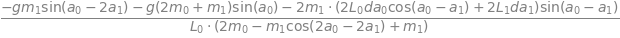

In [8]:
# Angular acceleration of the first link
ddang_0 = (
    -g * (2 * m[0] + m[1]) * sf.sin(ang[0])
    - m[1] * g * sf.sin(ang[0] - 2 * ang[1])
    - 2
    * sf.sin(ang[0] - ang[1])
    * m[1]
    * (dang[1] * 2 * L[1] + dang[0] * 2 * L[0] * sf.cos(ang[0] - ang[1]))
) / (L[0] * (2 * m[0] + m[1] - m[1] * sf.cos(2 * ang[0] - 2 * ang[1])))
display(ddang_0)

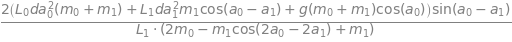

In [9]:
# Angular acceleration of the second link
ddang_1 = (
    2
    * sf.sin(ang[0] - ang[1])
    * (
        dang[0] ** 2 * L[0] * (m[0] + m[1])
        + g * (m[0] + m[1]) * sf.cos(ang[0])
        + dang[1] ** 2 * L[1] * m[1] * sf.cos(ang[0] - ang[1])
    )
) / (L[1] * (2 * m[0] + m[1] - m[1] * sf.cos(2 * ang[0] - 2 * ang[1])))
display(ddang_1)

In [10]:
# Organize the input symbols into a Values hierarchy:
inputs = Values()

inputs["ang"] = ang
inputs["dang"] = dang

with inputs.scope("constants"):
    inputs["g"] = g

with inputs.scope("params"):
    inputs["L"] = L
    inputs["m"] = m

display(inputs)

Values(
  ang: [a0, a1],
  dang: [da0, da1],
  constants:   Values(
    g: g,
  ),
  params:   Values(
    L: [L0, L1],
    m: [m0, m1],
  ),
)

In [11]:
# The output will simply be a 2-vector of the angular accelerations:
outputs = Values(ddang=sf.V2(ddang_0, ddang_1))

display(outputs)

Values(
  ddang: [(-g*(2*m0 + m1)*sin(a0) + g*sin(-a0 + 2*a1)*m1 + 2*sin(-a0 + a1)*m1*(2*L1*da1 + 2*cos(-a0 + a1)*L0*da0))/(L0*(2*m0 + m1 - cos(-2*a0 + 2*a1)*m1))]
[-2*sin(-a0 + a1)*(g*(m0 + m1)*cos(a0) + (m0 + m1)*L0*da0**2 + cos(-a0 + a1)*m1*L1*da1**2)/(L1*(2*m0 + m1 - cos(-2*a0 + 2*a1)*m1))],
)

In [12]:
# Run code generation to produce an executable module (in a temp directory if none provided):
double_pendulum = codegen.Codegen(
    inputs=inputs,
    outputs=outputs,
    config=codegen.CppConfig(),
    name="double_pendulum",
    return_key="ddang",
)
double_pendulum_data = double_pendulum.generate_function()

# Print what we generated
print("Files generated in {}:\n".format(double_pendulum_data.output_dir))
for f in double_pendulum_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, double_pendulum_data.output_dir)))

Files generated in /tmp/sf_codegen_double_pendulum_37wmnixm:

  |- lcmtypes/double_pendulum.lcm
  |- cpp/symforce/sym/double_pendulum.h


In [13]:
display_code_file(double_pendulum_data.function_dir / "double_pendulum.h", "C++")

In [14]:
# can also generate functions with different function declarations:
# Function using structs as inputs and outputs (returned as pointer arg)
input_values = Values(inputs=inputs)
output_values = Values(outputs=outputs)
namespace = "double_pendulum"
double_pendulum_values = codegen.Codegen(
    inputs=input_values,
    outputs=output_values,
    config=codegen.CppConfig(),
    name="double_pendulum",
)
double_pendulum_values_data = double_pendulum_values.generate_function(
    namespace=namespace,
)

# Print what we generated. Note the nested structs that were automatically
# generated.
print("Files generated in {}:\n".format(double_pendulum_values_data.output_dir))
for f in double_pendulum_values_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, double_pendulum_values_data.output_dir)))

display_code_file(
    double_pendulum_values_data.function_dir / "double_pendulum.h",
    "C++",
)

Files generated in /tmp/sf_codegen_double_pendulum_7481zpoh:

  |- lcmtypes/double_pendulum.lcm
  |- cpp/symforce/double_pendulum/double_pendulum.h


In [15]:
# can generate the same function in other languages as well:
namespace = "double_pendulum"
double_pendulum_python = codegen.Codegen(
    inputs=inputs,
    outputs=outputs,
    config=codegen.PythonConfig(use_eigen_types=False),
    name="double_pendulum",
    return_key="ddang",
)
double_pendulum_python_data = double_pendulum_python.generate_function(
    namespace=namespace,
)

print("Files generated in {}:\n".format(double_pendulum_python_data.output_dir))
for f in double_pendulum_python_data.generated_files:
    print("  |- {}".format(os.path.relpath(f, double_pendulum_python_data.output_dir)))

display_code_file(
    double_pendulum_python_data.function_dir / "double_pendulum.py",
    "python",
)

Files generated in /tmp/sf_codegen_double_pendulum_c36x8cq1:

  |- lcmtypes/double_pendulum.lcm
  |- python/symforce/double_pendulum/double_pendulum.py
  |- python/symforce/double_pendulum/__init__.py


In [16]:
constants_t = codegen_util.load_generated_lcmtype(
    namespace, "constants_t", double_pendulum_python_data.python_types_dir
)

params_t = codegen_util.load_generated_lcmtype(
    namespace, "params_t", double_pendulum_python_data.python_types_dir
)

ang = np.array([[0.0, 0.5]])
dang = np.array([[0.0, 0.0]])
consts = constants_t()
consts.g = 9.81
params = params_t()
params.L = [0.5, 0.3]
params.m = [0.3, 0.2]

gen_module = codegen_util.load_generated_package(
    namespace, double_pendulum_python_data.function_dir
)
gen_module.double_pendulum(ang, dang, consts, params)

array([[  4.77199518],
       [-22.65691471]])